<a href="https://colab.research.google.com/github/kskola/fraud-prediction/blob/main/Churn_predictive_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [113]:
# importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import joblib

In [114]:
data = pd.read_csv('/content/Customer_Data.csv')
data.head()

,Customer_ID,Gender,Age,Married,State,Number_of_Referrals,Tenure_in_Months,Value_Deal,Phone_Service,Multiple_Lines,...,Payment_Method,Monthly_Charge,Total_Charges,Total_Refunds,Total_Extra_Data_Charges,Total_Long_Distance_Charges,Total_Revenue,Customer_Status,Churn_Category,Churn_Reason
0,19877-DEL,Male,35,No,Delhi,7,27,NaN,Yes,No,...,Credit Card,65.6,593.30,0.00,0,381.51,974.81,Stayed,NaN,NaN
1,58353-MAH,Female,45,Yes,Maharashtra,14,13,NaN,Yes,Yes,...,Credit Card,-4.0,542.40,38.33,10,96.21,610.28,Stayed,NaN,NaN
2,25063-WES,Male,51,No,West Bengal,4,35,Deal 5,Yes,No,...,Bank Withdrawal,73.9,280.85,0.00,0,134.60,415.45,Churned,Competitor,Competitor had better devices
3,59787-KAR,Male,79,No,Karnataka,3,21,Deal 4,Yes,No,...,Bank Withdrawal,98.0,1237.85,0.00,0,361.66,1599.51,Churned,Dissatisfaction,Product dissatisfaction
4,28544-TAM,Female,80,No,Tamil Nadu,3,8,NaN,Yes,No,...,Credit Card,83.9,267.40,0.00,0,22.14,289.54,Churned,Dissatisfaction,Network reliability


data preprocessing

In [115]:
# Drop columns that won't be used for prediction
data = data.drop(['Customer_ID', 'Churn_Category', 'Churn_Reason'], axis=1, errors= 'ignore')

# List of columns to be label encoded
columns_to_encode = [
    'Gender', 'Married', 'State', 'Value_Deal', 'Phone_Service', 'Multiple_Lines',
    'Internet_Service', 'Internet_Type', 'Online_Security', 'Online_Backup',
    'Device_Protection_Plan', 'Premium_Support', 'Streaming_TV', 'Streaming_Movies',
    'Streaming_Music', 'Unlimited_Data', 'Contract', 'Paperless_Billing',
    'Payment_Method'
]

label_encoders = {}
for column in columns_to_encode:
    label_encoders[column] = LabelEncoder()
    data[column] = label_encoders[column].fit_transform(data[column])

data.head()

,Gender,Age,Married,State,Number_of_Referrals,Tenure_in_Months,Value_Deal,Phone_Service,Multiple_Lines,Internet_Service,...,Contract,Paperless_Billing,Payment_Method,Monthly_Charge,Total_Charges,Total_Refunds,Total_Extra_Data_Charges,Total_Long_Distance_Charges,Total_Revenue,Customer_Status
0,1,35,0,4,7,27,5,1,0,1,...,1,1,1,65.6,593.30,0.00,0,381.51,974.81,Stayed
1,0,45,1,12,14,13,5,1,1,1,...,0,0,1,-4.0,542.40,38.33,10,96.21,610.28,Stayed
2,1,51,0,21,4,35,4,1,0,1,...,0,1,0,73.9,280.85,0.00,0,134.60,415.45,Churned
3,1,79,0,9,3,21,3,1,0,1,...,0,1,0,98.0,1237.85,0.00,0,361.66,1599.51,Churned
4,0,80,0,17,3,8,5,1,0,1,...,0,1,1,83.9,267.40,0.00,0,22.14,289.54,Churned


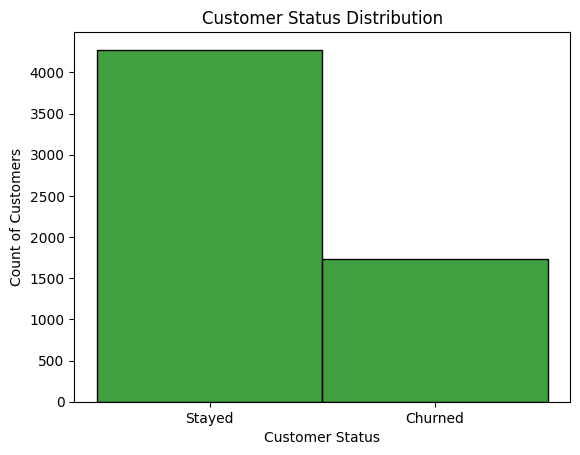

In [116]:
sns.histplot(data['Customer_Status'], color='green')
plt.title('Customer Status Distribution')
plt.xlabel('Customer Status')
plt.ylabel('Count of Customers')
plt.show()

In [117]:
# encode the target variable 'Customer_Status' seperately
data['Customer_Status'] = data['Customer_Status'].map({'Stayed': 0, 'Churned': 1})
data.head()

,Gender,Age,Married,State,Number_of_Referrals,Tenure_in_Months,Value_Deal,Phone_Service,Multiple_Lines,Internet_Service,...,Contract,Paperless_Billing,Payment_Method,Monthly_Charge,Total_Charges,Total_Refunds,Total_Extra_Data_Charges,Total_Long_Distance_Charges,Total_Revenue,Customer_Status
0,1,35,0,4,7,27,5,1,0,1,...,1,1,1,65.6,593.30,0.00,0,381.51,974.81,0
1,0,45,1,12,14,13,5,1,1,1,...,0,0,1,-4.0,542.40,38.33,10,96.21,610.28,0
2,1,51,0,21,4,35,4,1,0,1,...,0,1,0,73.9,280.85,0.00,0,134.60,415.45,1
3,1,79,0,9,3,21,3,1,0,1,...,0,1,0,98.0,1237.85,0.00,0,361.66,1599.51,1
4,0,80,0,17,3,8,5,1,0,1,...,0,1,1,83.9,267.40,0.00,0,22.14,289.54,1


In [118]:
# Split data into features and target
X = data.drop('Customer_Status', axis=1)
y = data['Customer_Status']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Train Random Forest Model

In [119]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

evaluatte model


Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.93      0.89       841
           1       0.80      0.63      0.70       361

    accuracy                           0.84      1202
   macro avg       0.83      0.78      0.80      1202
weighted avg       0.84      0.84      0.84      1202



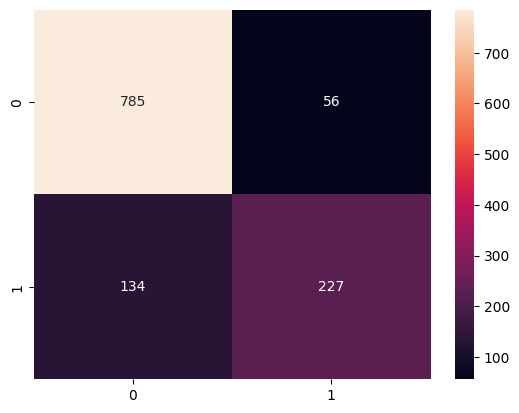

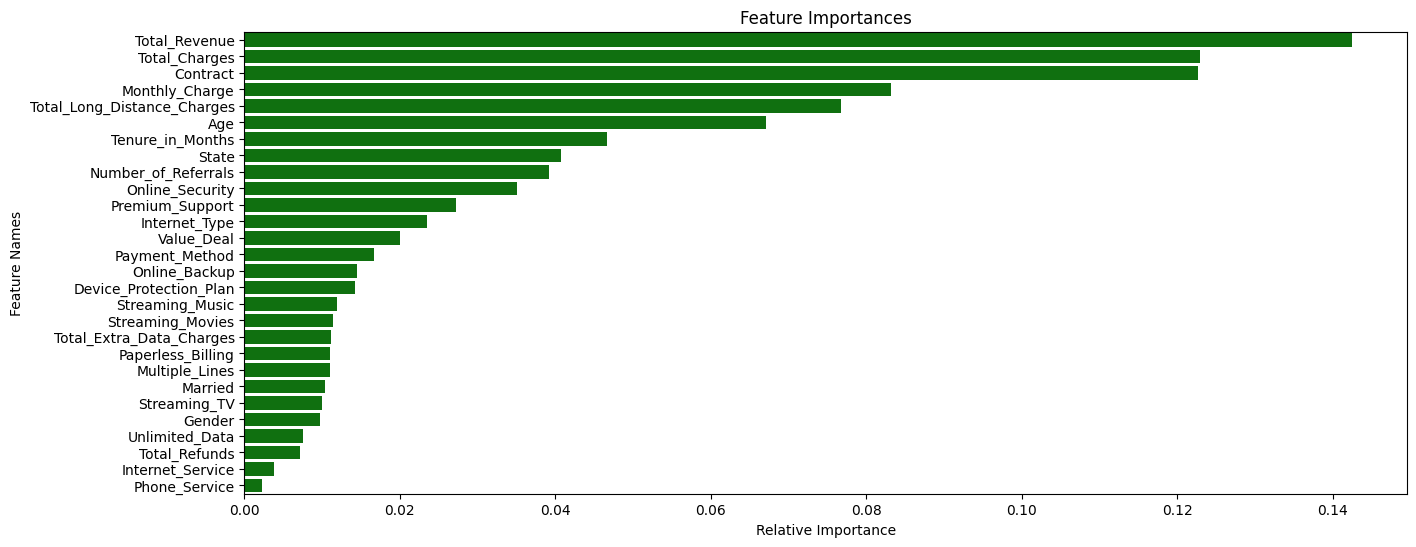

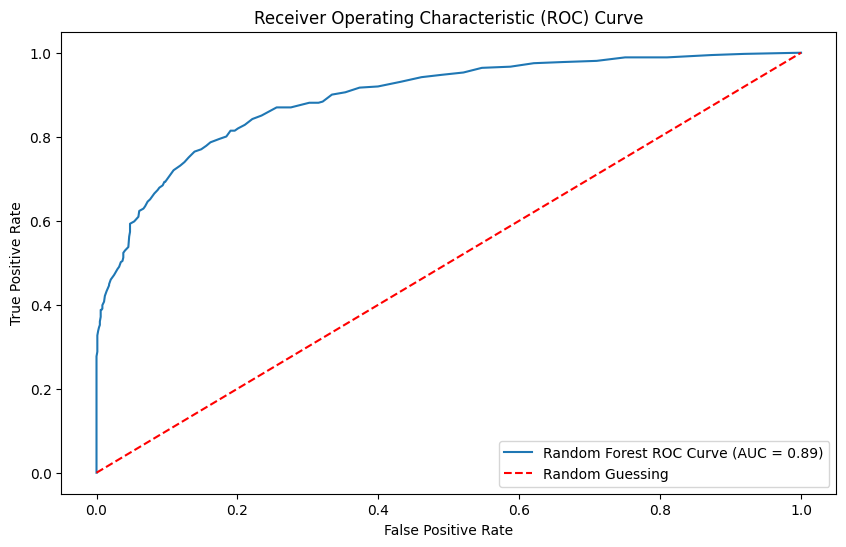

In [121]:
# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g')

# Feature Selection using Feature Importance
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(15, 6))
sns.barplot(x=importances[indices], y=X.columns[indices], color= 'green')
plt.title('Feature Importances')
plt.xlabel('Relative Importance')
plt.ylabel('Feature Names')
plt.show()

# Get predicted probabilities for +ve class
y_probs = model.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'Random Forest ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()